In [ ]:
# I aim to predict close price for BTC in DataFrame

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import data from API

In [3]:
pip install twelvedata

Could not fetch URL https://pypi.org/simple/twelvedata/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/twelvedata/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement twelvedata (from versions: none)
ERROR: No matching distribution found for twelvedata


In [83]:
# Twelvedata.com api:
from twelvedata import TDClient
api_key='8667389e10c04e1f9d30d43dd9586f1e'
td = TDClient(apikey=api_key)
 
df = td.time_series(
    symbol="BTC/USD",
    interval="4h",
    outputsize=5000).as_pandas()
 
df

,open,high,low,close
datetime,,,,
2023-02-27 12:00:00,23426.41992,23887.00000,23382.09961,23543.98047
2023-02-27 08:00:00,23423.43945,23453.41016,23340.85938,23425.71094
2023-02-27 04:00:00,23552.58984,23557.91992,23351.69922,23427.67969
2023-02-27 00:00:00,23558.92969,23642.73047,23435.61914,23554.53906
2023-02-26 20:00:00,23516.85938,23680.34961,23332.09961,23558.92969
...,...,...,...,...
2021-05-16 12:00:00,49063.01172,49232.50000,47767.85156,47767.85156
2021-05-16 08:00:00,49370.26172,49770.16016,48714.07031,49059.14844
2021-05-16 04:00:00,48384.94922,49449.46875,48068.67969,49367.57812


# Dataset check & plots

In [84]:
df.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

In [85]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3905 entries, 2023-02-27 12:00:00 to 2021-05-15 20:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3905 non-null   float64
 1   high    3905 non-null   float64
 2   low     3905 non-null   float64
 3   close   3905 non-null   float64
dtypes: float64(4)
memory usage: 152.5 KB


array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>]], dtype=object)

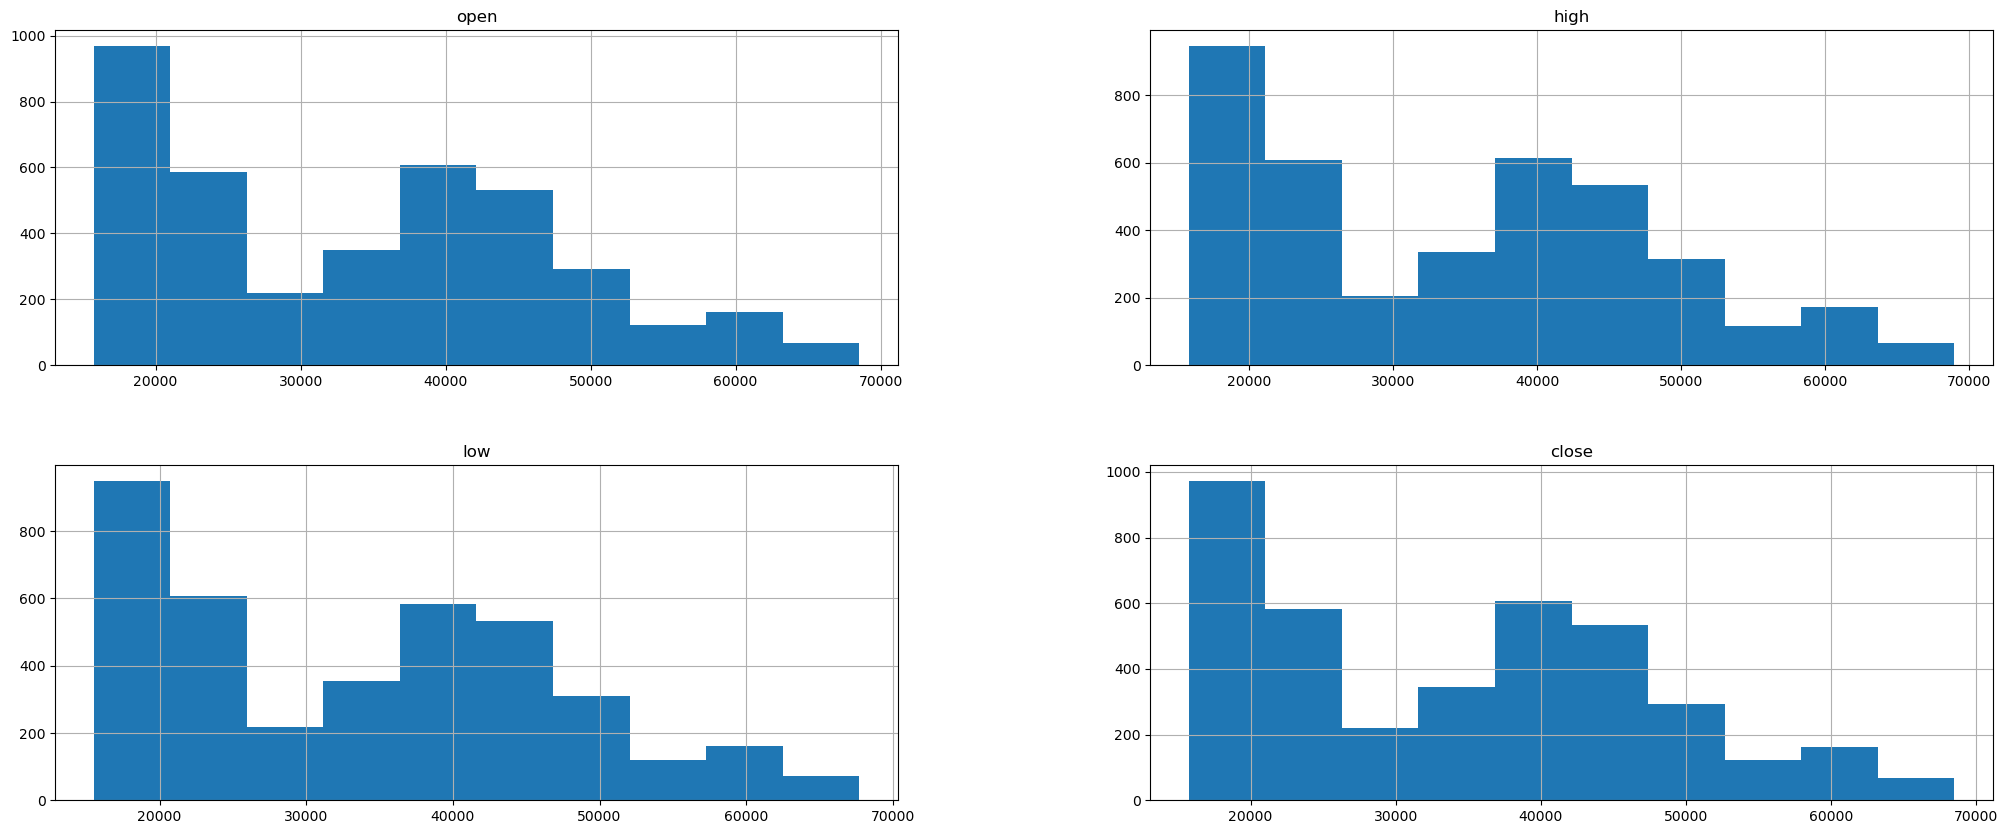

In [87]:
df.hist(figsize=(25,10))

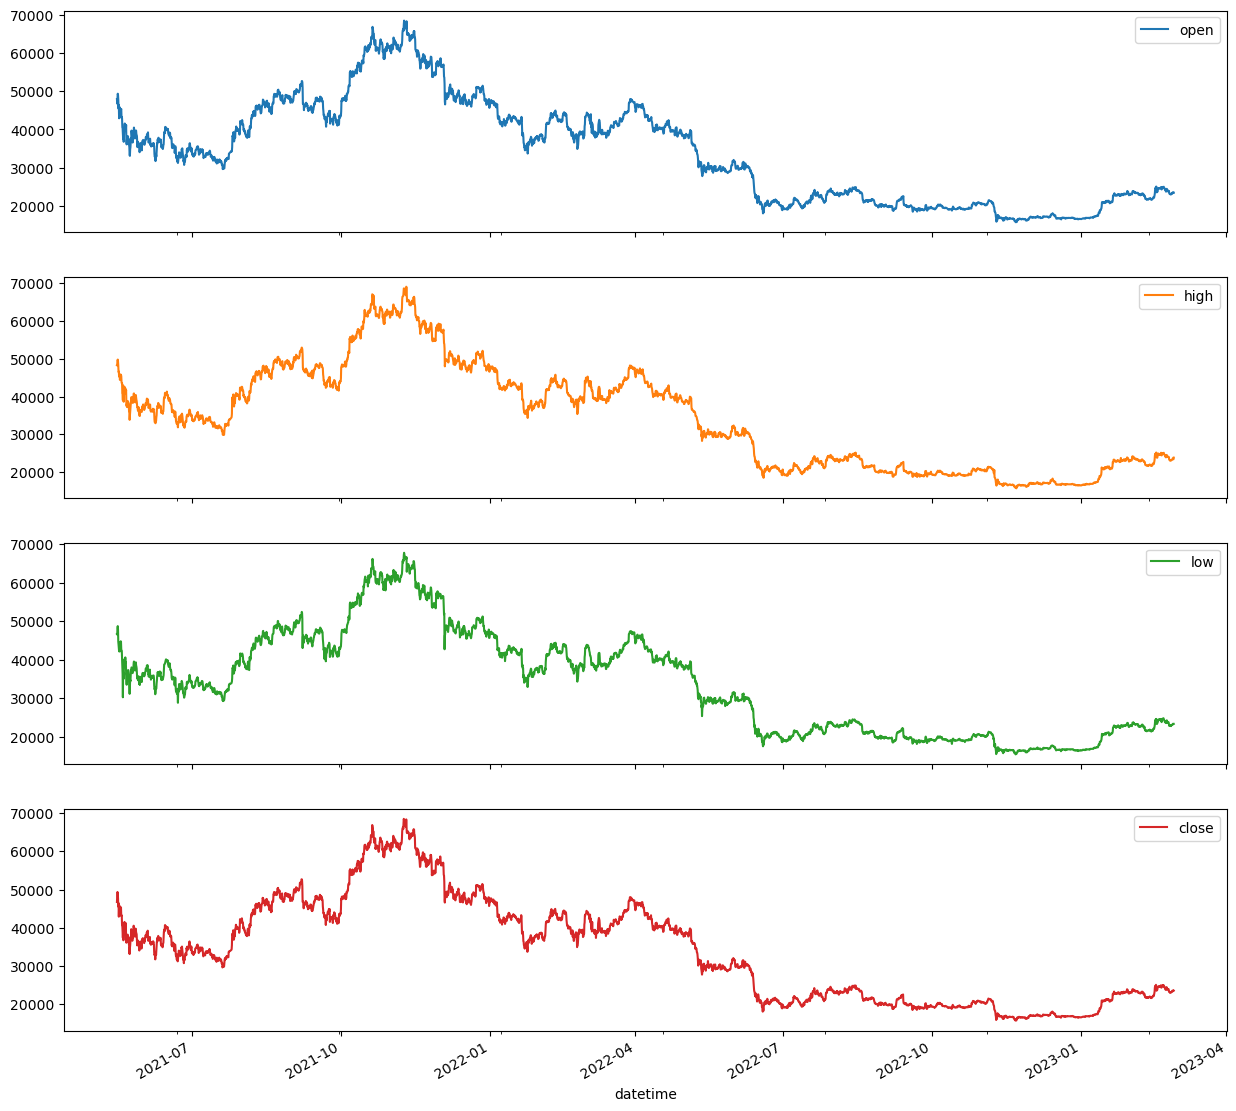

In [88]:
df.plot(subplots=True, figsize=(15,15))
plt.show()

<AxesSubplot:xlabel='datetime'>

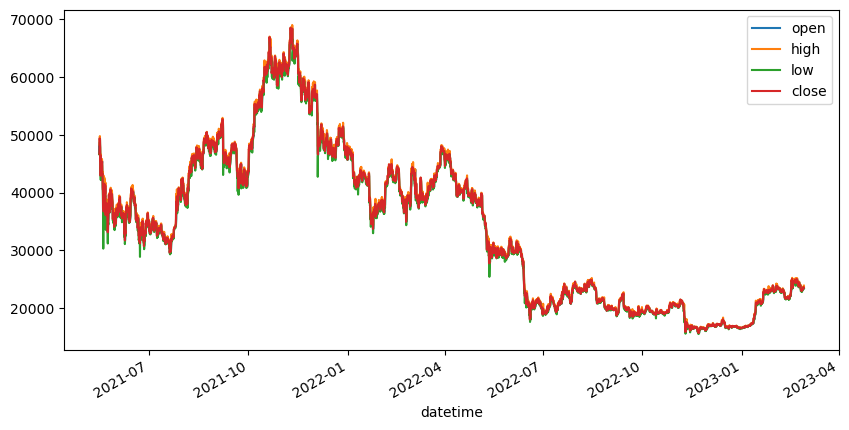

In [89]:
df.plot(figsize=(10,5)) 

# choose the optimal lag observation

In [90]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [91]:
import statsmodels.tsa.stattools as sts

In [101]:
sts.adfuller(df.close) # 

(-1.1486168851075496,
 0.6953000568211438,
 6,
 3898,
 {'1%': -3.4320287099894067,
  '5%': -2.862281762142953,
  '10%': -2.567164848800914},
 59896.857290054155)

In [104]:
df_diff=df['close'].diff().dropna()  # df['close'] is the column that I want to predict

(-0.1, 0.1)

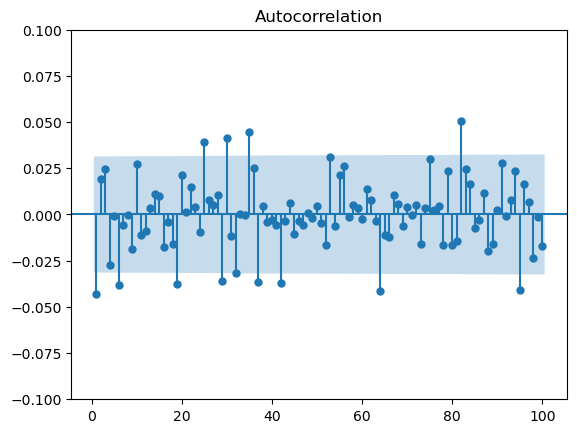

In [105]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_diff, lags=100, zero=False) 
plt.ylim(-0.1,0.1)




(-0.1, 0.1)

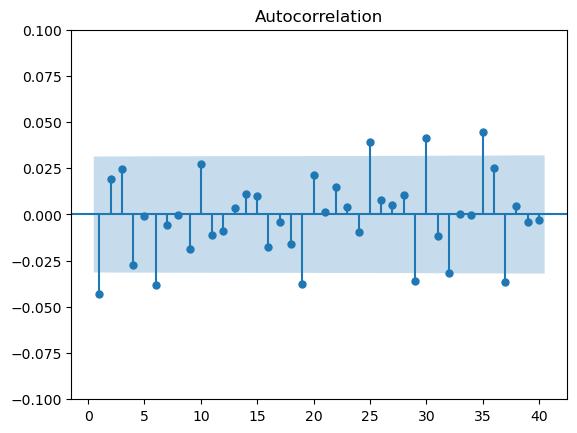

In [99]:
plot_acf(df_diff, lags=40, zero=False) 
plt.ylim(-0.1,0.1)

In [107]:
# optimal lag is 25 then:
lag=25

# data prepration

In [190]:
train_size =int(len(df)*0.8)
#df=np.arry(df)  

In [ ]:
# dataset matrix

def to_sequences_multivariable_multistepprediction(dataset, target,start_index, end_index, 
                 seq_size, target_size, step, single_step=False):
    
    data=[]
    labels=[]
    start_index=start_index+seq_size
    
    if end_index is None:
        end_index= len(dataset)-target_size
        
    for i in range(start_index, end_index):
        indices=range(i-seq_size, i, step)
        
        data.append(dataset.iloc[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)
    
STEP=1 
n_step = 3 


xtrain,ytrain= to_sequences_multivariable_multistepprediction(df,df['close'],0,          train_size,lag, n_step, STEP, single_step=False)
xtest, ytest=  to_sequences_multivariable_multistepprediction(df,df['close'],train_size, None,      lag, n_step, STEP, single_step=False)

In [122]:
print(xtrain.shape ,  xtest.shape) #(n_sample, seq_size, n_features)
print(ytrain.shape, ytest.shape) #(n_samples, n_step)

(3099, 25, 4) (753, 25, 4)
(3099, 3) (753, 3)


In [128]:
# scaling
from sklearn.preprocessing import MinMaxScaler

xtrain_scaled=np.zeros_like(xtrain)
xtest_scaled=np.zeros_like(xtest)

scaler={}  

for i in range(xtrain.shape[1]):
    scaler[i]=MinMaxScaler(feature_range=(0,1))
    xtrain_scaled[:,i,:] = scaler[i].fit_transform(xtrain[:,i,:]) 

for i in range(xtest.shape[1]):    
    xtest_scaled[:,i,:] = scaler[i].transform(xtest[:,i,:])

In [129]:
xtrain_scaled.shape,xtest_scaled.shape

((3099, 25, 4), (753, 25, 4))

In [130]:
scaler

{0: MinMaxScaler(),
 1: MinMaxScaler(),
 2: MinMaxScaler(),
 3: MinMaxScaler(),
 4: MinMaxScaler(),
 5: MinMaxScaler(),
 6: MinMaxScaler(),
 7: MinMaxScaler(),
 8: MinMaxScaler(),
 9: MinMaxScaler(),
 10: MinMaxScaler(),
 11: MinMaxScaler(),
 12: MinMaxScaler(),
 13: MinMaxScaler(),
 14: MinMaxScaler(),
 15: MinMaxScaler(),
 16: MinMaxScaler(),
 17: MinMaxScaler(),
 18: MinMaxScaler(),
 19: MinMaxScaler(),
 20: MinMaxScaler(),
 21: MinMaxScaler(),
 22: MinMaxScaler(),
 23: MinMaxScaler(),
 24: MinMaxScaler()}

In [142]:
# scale ytrain , ytest

scaler_y=MinMaxScaler(feature_range=(0,1))
ytrain_scaled=scaler_y.fit_transform(ytrain)
ytest_scaled=scaler_y.transform(ytest)

In [132]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,GRU,SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dropout

# simple RNN

In [170]:
RNN_model=Sequential()
RNN_model.add(SimpleRNN(50, input_shape=xtrain.shape[-2:], activation='relu',return_sequences=True))
# RNN_model.add(Dropout(0.3))
RNN_model.add(SimpleRNN(50,  activation='relu',kernel_regularizer='l2'))
# RNN_model.add(Dropout(0.3))
RNN_model.add(Dense(n_step,  activation='selu'))



RNN_model.compile(optimizer='adam', loss='mse')

history_RNN=RNN_model.fit(xtrain_scaled,ytrain_scaled, epochs=30, batch_size=16, validation_data=[xtest_scaled,ytest_scaled])



Epoch 1/30
194/194 [==============================] - 15s 44ms/step - loss: 0.2277 - val_loss: 0.0638
Epoch 2/30
194/194 [==============================] - 8s 40ms/step - loss: 0.0290 - val_loss: 0.0119
Epoch 3/30
194/194 [==============================] - 8s 40ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 4/30
194/194 [==============================] - 7s 38ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/30
194/194 [==============================] - 7s 38ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/30
194/194 [==============================] - 8s 39ms/step - loss: 9.8262e-04 - val_loss: 9.8889e-04
Epoch 7/30
194/194 [==============================] - 7s 38ms/step - loss: 7.4582e-04 - val_loss: 0.0016
Epoch 8/30
194/194 [==============================] - 8s 40ms/step - loss: 6.0737e-04 - val_loss: 9.3118e-04
Epoch 9/30
194/194 [==============================] - 7s 37ms/step - loss: 5.5058e-04 - val_loss: 7.3363e-04
Epoch 10/30
194/194 [==============================] - 7s 38ms

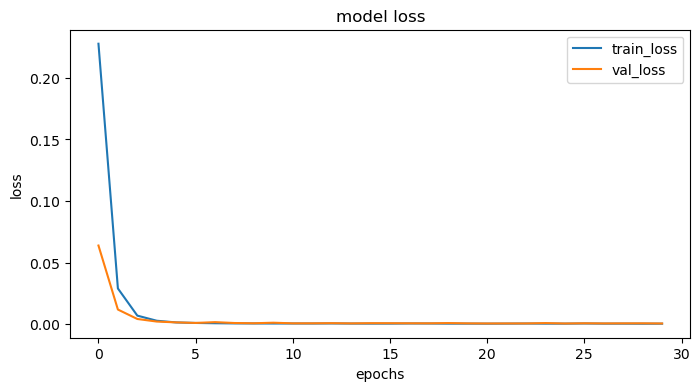

In [171]:
plt.figure(figsize=(8,4))
plt.plot(history_RNN.history['loss'], label='train_loss')
plt.plot(history_RNN.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [157]:
ypred_RNN=RNN_model.predict(xtest_scaled)

# invesre prediction:
ypred_RNN_back_to_unscale=scaler_y.inverse_transform(ypred_RNN)

from sklearn.metrics import mean_squared_error
mse_RNN1=mean_squared_error(ytest,ypred_RNN_back_to_unscale) #mse for back_to_unscaled versions
mse_RNN2=mean_squared_error(ytest_scaled,ypred_RNN) #mse for scaled versions

mse_RNN1 , mse_RNN2

24/24 [==============================] - 0s 15ms/step


(957056.7656305609, 0.0003434654332664535)

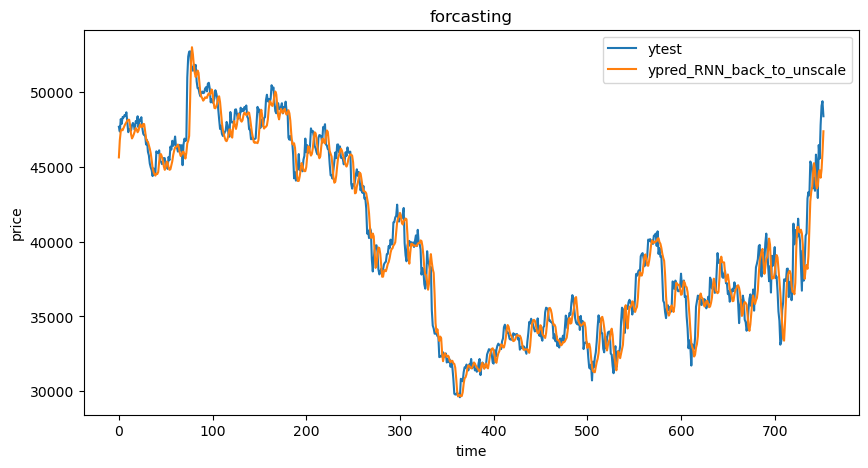

In [164]:
plt.figure(figsize=(10,5))
plt.plot(ytest[:,2], label='ytest') 
plt.plot(ypred_RNN_back_to_unscale[:,2], label='ypred_RNN_back_to_unscale')
plt.title('forcasting')
plt.ylabel('price')
plt.xlabel('time')
plt.legend()
plt.show()

In [162]:
# forcast future yande
future_prediction=RNN_model(xtrain_scaled[-1:,:,:])
future_prediction_back_to_unscaled=scaler_y.inverse_transform(future_prediction)
future_prediction_back_to_unscaled

array([[42005.51354298, 42297.55643395, 41994.66963816]])

# GRU

In [165]:
GRU_model=Sequential()
GRU_model.add(GRU(50, input_shape=xtrain.shape[-2:], activation='relu',return_sequences=True))
# GRU_model.add(Dropout(0.3))
GRU_model.add(GRU(50, activation='relu'))#,kernel_regularizer='l2' 
# GRU_model.add(Dropout(0.3))
GRU_model.add(Dense(n_step,  activation='selu'))


GRU_model.compile(optimizer='adam', loss='mse')

history_GRU=GRU_model.fit(xtrain_scaled,ytrain_scaled, epochs=30, batch_size=16, validation_data=[xtest_scaled,ytest_scaled])



Epoch 1/30
194/194 [==============================] - 28s 89ms/step - loss: 0.0102 - val_loss: 4.5267e-04
Epoch 2/30
194/194 [==============================] - 17s 87ms/step - loss: 2.2623e-04 - val_loss: 3.8866e-04
Epoch 3/30
194/194 [==============================] - 17s 89ms/step - loss: 1.7920e-04 - val_loss: 3.4431e-04
Epoch 4/30
194/194 [==============================] - 18s 91ms/step - loss: 1.7725e-04 - val_loss: 3.1429e-04
Epoch 5/30
194/194 [==============================] - 15s 79ms/step - loss: 1.7731e-04 - val_loss: 3.0061e-04
Epoch 6/30
194/194 [==============================] - 16s 83ms/step - loss: 1.5678e-04 - val_loss: 2.9161e-04
Epoch 7/30
194/194 [==============================] - 16s 83ms/step - loss: 1.4711e-04 - val_loss: 2.9720e-04
Epoch 8/30
194/194 [==============================] - 15s 78ms/step - loss: 1.3955e-04 - val_loss: 2.6926e-04
Epoch 9/30
194/194 [==============================] - 15s 77ms/step - loss: 1.5129e-04 - val_loss: 2.8935e-04
Epoch 10/30
19

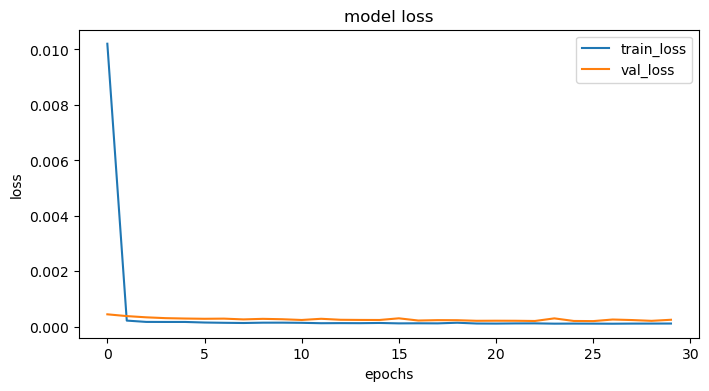

In [166]:
plt.figure(figsize=(8,4))
plt.plot(history_GRU.history['loss'], label='train_loss')
plt.plot(history_GRU.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [167]:
ypred_GRU=GRU_model.predict(xtest_scaled)

# invesre prediction:
ypred_GRU_back_to_unscale=scaler_y.inverse_transform(ypred_GRU)

from sklearn.metrics import mean_squared_error
mse_GRU1=mean_squared_error(ytest,ypred_GRU_back_to_unscale) #mse for back_to_unscaled versions
mse_GRU2=mean_squared_error(ytest_scaled,ypred_GRU) #mse for scaled versions

mse_GRU1 , mse_GRU2

24/24 [==============================] - 2s 28ms/step


(713387.63806161, 0.0002560182019842668)

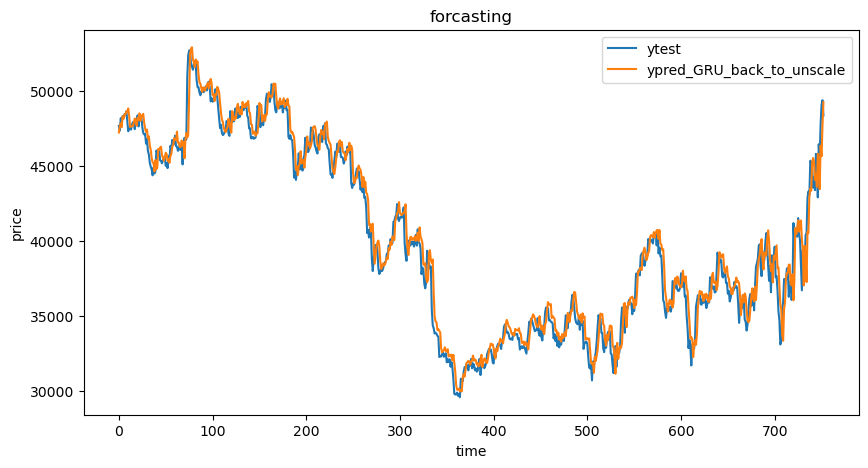

In [168]:
plt.figure(figsize=(10,5))
plt.plot(ytest[:,2], label='ytest') 
plt.plot(ypred_GRU_back_to_unscale[:,2], label='ypred_GRU_back_to_unscale')
plt.title('forcasting')
plt.ylabel('price')
plt.xlabel('time')
plt.legend()
plt.show()

In [169]:
# forcast future 
future_prediction=GRU_model(xtrain_scaled[-1:,:,:])
future_prediction_back_to_unscaled=scaler_y.inverse_transform(future_prediction)
future_prediction_back_to_unscaled

array([[44598.80828922, 44800.4297211 , 44536.32801591]])

# LSTM

In [172]:
LSTM_model=Sequential()
LSTM_model.add(LSTM(50, input_shape=xtrain.shape[-2:], activation='relu',return_sequences=True))
# LSTM_model.add(Dropout(0.3))
LSTM_model.add(LSTM(50, activation='relu',return_sequences=True))
LSTM_model.add(LSTM(50,  activation='relu'))
# LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(n_step,  activation='selu'))



LSTM_model.compile(optimizer='adam', loss='mse')

history_LSTM=LSTM_model.fit(xtrain_scaled,ytrain_scaled, epochs=30, batch_size=16, validation_data=[xtest_scaled,ytest_scaled])



Epoch 1/30
194/194 [==============================] - 41s 141ms/step - loss: 0.0129 - val_loss: 0.0016
Epoch 2/30
194/194 [==============================] - 24s 123ms/step - loss: 8.0507e-04 - val_loss: 0.0014
Epoch 3/30
194/194 [==============================] - 23s 117ms/step - loss: 7.2603e-04 - val_loss: 0.0013
Epoch 4/30
194/194 [==============================] - 24s 126ms/step - loss: 7.8009e-04 - val_loss: 0.0012
Epoch 5/30
194/194 [==============================] - 23s 121ms/step - loss: 6.5071e-04 - val_loss: 0.0014
Epoch 6/30
194/194 [==============================] - 25s 129ms/step - loss: 6.1273e-04 - val_loss: 9.5728e-04
Epoch 7/30
194/194 [==============================] - 24s 126ms/step - loss: 5.0396e-04 - val_loss: 8.5951e-04
Epoch 8/30
194/194 [==============================] - 24s 123ms/step - loss: 5.2144e-04 - val_loss: 8.9467e-04
Epoch 9/30
194/194 [==============================] - 23s 120ms/step - loss: 5.4550e-04 - val_loss: 8.9401e-04
Epoch 10/30
194/194 [====

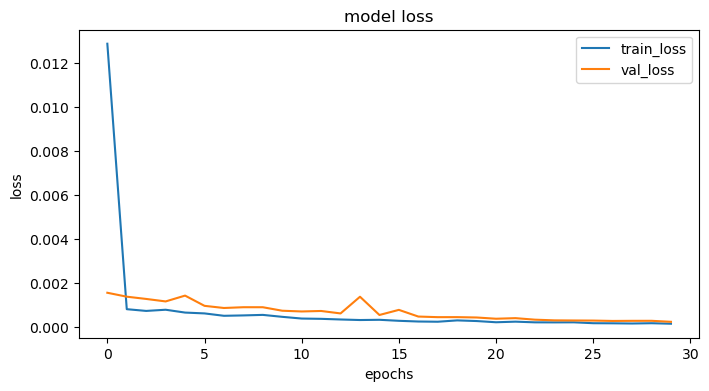

In [173]:
plt.figure(figsize=(8,4))
plt.plot(history_LSTM.history['loss'], label='train_loss')
plt.plot(history_LSTM.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [174]:
ypred_LSTM=LSTM_model.predict(xtest_scaled)

# invesre prediction:
ypred_LSTM_back_to_unscale=scaler_y.inverse_transform(ypred_LSTM)

from sklearn.metrics import mean_squared_error
mse_LSTM1=mean_squared_error(ytest,ypred_LSTM_back_to_unscale) #mse for back_to_unscaled versions
mse_LSTM2=mean_squared_error(ytest_scaled,ypred_LSTM) #mse for scaled versions

mse_LSTM1 , mse_LSTM2

24/24 [==============================] - 3s 46ms/step


(641377.2082277014, 0.00023017538520105464)

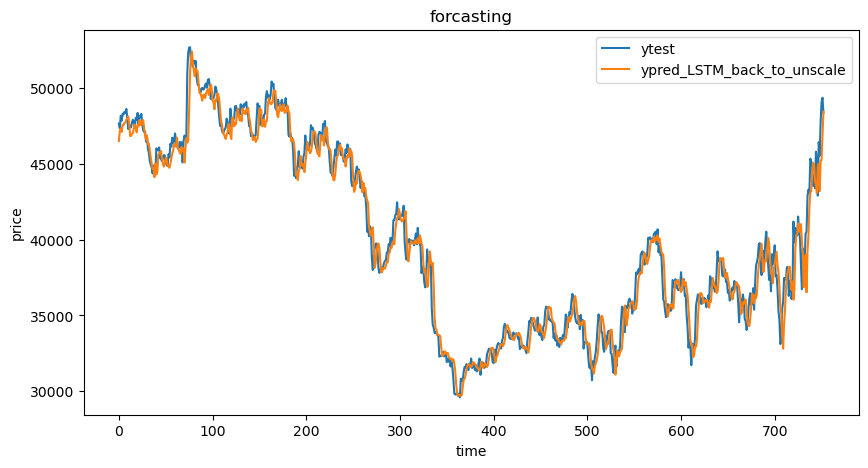

In [175]:
plt.figure(figsize=(10,5))
plt.plot(ytest[:,2], label='ytest') 
plt.plot(ypred_LSTM_back_to_unscale[:,2], label='ypred_LSTM_back_to_unscale')
plt.title('forcasting')
plt.ylabel('price')
plt.xlabel('time')
plt.legend()
plt.show()

In [176]:
# forcast future 
future_prediction=LSTM_model(xtrain_scaled[-1:,:,:])
future_prediction_back_to_unscaled=scaler_y.inverse_transform(future_prediction)
future_prediction_back_to_unscaled

array([[43505.72443422, 43762.19623395, 43551.3528421 ]])

# CNN1D

In [183]:
from keras.layers import BatchNormalization, MaxPooling1D 
from keras import layers 
    
    
CNN_model=Sequential()
CNN_model.add(Conv1D(64, kernel_size=3, input_shape=xtrain.shape[-2:], activation='relu'))
# CNN_model.add(Dropout(0.2))
# CNN_model.add(BatchNormalization())
# CNN_model.add(Maxpooling1D(pool_size=2))
CNN_model.add(layers.MaxPooling1D((2)))
# CNN_model.add(BatchNormalization())
CNN_model.add(Flatten())
CNN_model.add(Dense(64,  activation='relu'))
# CNN_model.add(Dropout(0.3))
# CNN_model.add(BatchNormalization())
CNN_model.add(Dense(n_step,  activation='selu'))



CNN_model.compile(optimizer='adam', loss='mse')

history_CNN=CNN_model.fit(xtrain_scaled,ytrain_scaled, epochs=30, batch_size=16, validation_data=[xtest_scaled,ytest_scaled])



Epoch 1/30
194/194 [==============================] - 5s 14ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 2/30
194/194 [==============================] - 2s 11ms/step - loss: 5.9973e-04 - val_loss: 0.0011
Epoch 3/30
194/194 [==============================] - 2s 11ms/step - loss: 5.4266e-04 - val_loss: 8.5291e-04
Epoch 4/30
194/194 [==============================] - 2s 10ms/step - loss: 4.6574e-04 - val_loss: 9.8456e-04
Epoch 5/30
194/194 [==============================] - 2s 12ms/step - loss: 4.2044e-04 - val_loss: 6.0438e-04
Epoch 6/30
194/194 [==============================] - 2s 12ms/step - loss: 3.8157e-04 - val_loss: 6.3512e-04
Epoch 7/30
194/194 [==============================] - 2s 12ms/step - loss: 3.1570e-04 - val_loss: 5.3401e-04
Epoch 8/30
194/194 [==============================] - 2s 12ms/step - loss: 3.7900e-04 - val_loss: 6.2291e-04
Epoch 9/30
194/194 [==============================] - 3s 13ms/step - loss: 3.4833e-04 - val_loss: 7.1494e-04
Epoch 10/30
194/194 [==========

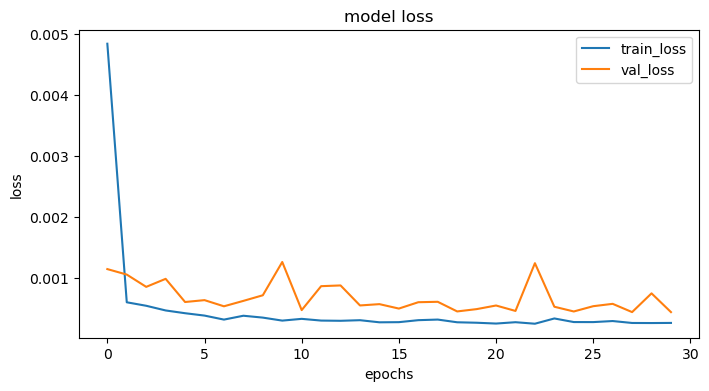

In [184]:
plt.figure(figsize=(8,4))
plt.plot(history_CNN.history['loss'], label='train_loss')
plt.plot(history_CNN.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [185]:
ypred_CNN=CNN_model.predict(xtest_scaled)

# invesre prediction:
ypred_CNN_back_to_unscale=scaler_y.inverse_transform(ypred_CNN)

from sklearn.metrics import mean_squared_error
mse_CNN1=mean_squared_error(ytest,ypred_CNN_back_to_unscale) #mse for back_to_unscaled versions
mse_CNN2=mean_squared_error(ytest_scaled,ypred_CNN) #mse for scaled versions

mse_CNN1 , mse_CNN2

24/24 [==============================] - 0s 7ms/step


(1222011.5049153918, 0.000438551552506279)

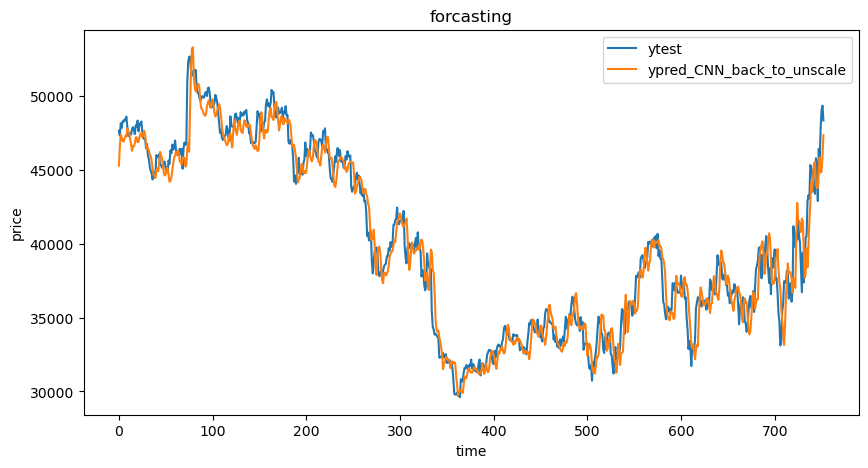

In [186]:
plt.figure(figsize=(10,5))
plt.plot(ytest[:,2], label='ytest') 
plt.plot(ypred_CNN_back_to_unscale[:,2], label='ypred_CNN_back_to_unscale')
plt.title('forcasting')
plt.ylabel('price')
plt.xlabel('time')
plt.legend()
plt.show()

In [187]:
# forcast future 
future_prediction=CNN_model(xtrain_scaled[-1:,:,:])
future_prediction_back_to_unscaled=scaler_y.inverse_transform(future_prediction)
future_prediction_back_to_unscaled

array([[41355.66269544, 41524.25214276, 41450.07372985]])

# compare

In [228]:
results={ 'RNN':mse_RNN2 ,'GRU':mse_GRU2, 'LSTM':mse_LSTM2, 'CNN1D':mse_CNN2} 
results

{'RNN': 0.0003434654332664535,
 'GRU': 0.0002560182019842668,
 'LSTM': 0.00023017538520105464,
 'CNN1D': 0.000438551552506279}

In [229]:
results=pd.Series(results)
results

RNN      0.000343
GRU      0.000256
LSTM     0.000230
CNN1D    0.000439
dtype: float64

In [230]:
results.sort_values(ascending=True)

LSTM     0.000230
GRU      0.000256
RNN      0.000343
CNN1D    0.000439
dtype: float64

<AxesSubplot:>

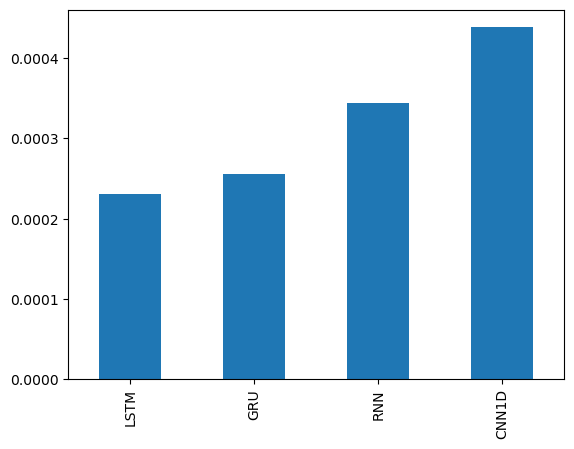

In [231]:
results.sort_values(ascending=True).plot(kind='bar')

In [ ]:
# Results compare: LSTM ~ GRU > RNN > CNN 
